In [1]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import matplotlib
from natsort import natsorted
from scipy.sparse.linalg import svds

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', size=12) 
%config InlineBackend.figure_format = 'svg'

In [2]:
path = '/Users/patrick/Documents/phd/GitHub/tikhonov/'

In [3]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))

def cnum(xbinw,ebinw,num_components,precond):
    R = []
    D = []

    for i in range(5,len(g4iso_files),ebinw): # 100 keV to 1 MeV energy range in steps of 100 keV
        R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:2000:xbinw,3]/5000000.0)
    R = np.transpose(np.array(R))
    
    if (precond):
        D = []
        for j in range(0,R.shape[0]): # X-ray spectra from 0 to 600 keV
            if (np.linalg.norm(R[j,:] > 0)):
                D.append((1.0/(np.linalg.norm(R[j,:]))**.5)) # Diagonal scaling as a left pre-conditioner
            else:
                D.append(1)

        DD = np.diag(D)
    else:
        DD = np.identity(R.shape[0])
    
    R = np.matmul(DD,R)
    return(np.linalg.cond(R))

In [4]:
def tsvd(num_components,precond):

    X = np.arange(10, 100, 5)
    Y = np.arange(1, 20, 1)
    XX, YY = np.meshgrid(X, Y)
    Z = []
    zm=[]
    for i in X:
        print(i)
        for j in Y:
            zm.append(cnum(i,j,num_components,precond))
        Z.append(zm)
        zm=[]
    ZZ = np.transpose(np.array(Z))
    return([XX,YY,ZZ])

In [5]:
cnum1 = tsvd(0,True)

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [6]:
cnum2 = tsvd(0,False)

10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


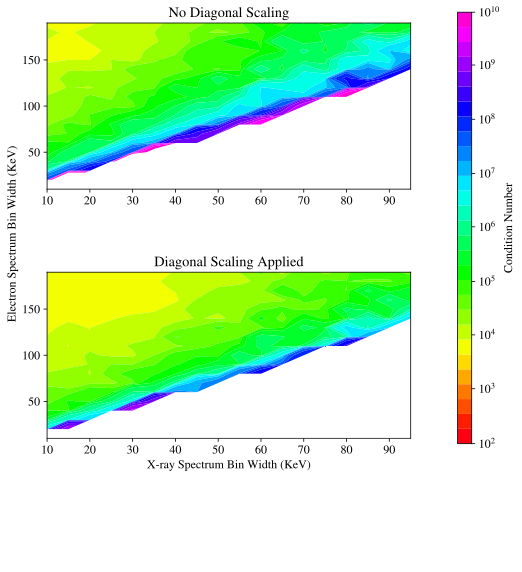

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker, cm

target = cnum1
target2 = cnum2
fig = plt.figure(figsize=(6.52437527778,7.5))

gs = plt.GridSpec(nrows=2, ncols=1,hspace=.5,wspace=.4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])


cs=ax2.contourf(target[0],target[1]*10,target[2],locator=ticker.LogLocator(),levels=np.logspace(2,10,30),cmap='gist_rainbow')
cs2=ax1.contourf(target2[0],target2[1]*10,target2[2],locator=ticker.LogLocator(),levels=np.logspace(2,10,30),cmap='gist_rainbow')
cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8]) 

cbar=fig.colorbar(cs,ticks=np.logspace(1,100,100),cax=cbaxes)

ax1.set_title('No Diagonal Scaling')
ax2.set_xlabel('X-ray Spectrum Bin Width (KeV)')
ax2.set_ylabel('                                                                                 Electron Spectrum Bin Width (KeV)')
ax2.set_title('Diagonal Scaling Applied')


cbar.ax.set_ylabel('Condition Number')

fig.savefig('condition_number_binning_diagonal_scaling.pdf',bbox_inches="tight")
plt.show()